In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from darts.models import NBEATSModel
from darts.datasets import AirPassengersDataset

In [2]:
df = pd.read_csv("csv/open-meteo-ynov-aix.csv", parse_dates=["time"])
df.set_index("time", inplace=True)
df = df.asfreq('h')  # les données sont supposées horaires
df.head()

,temperature_2m (°C),surface_pressure (hPa),wind_speed_100m (km/h),wind_speed_10m (km/h),wind_direction_10m (°),wind_direction_100m (°),cloud_cover (%),snowfall (cm),rain (mm),precipitation (mm),apparent_temperature (°C),relative_humidity_2m (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%)
time,,,,,,,,,,,,,,,
2010-01-01 00:00:00,8.7,971.2,10.7,6.4,133,147,58,0.0,0.0,0.0,7.3,96,44,2,24
2010-01-01 01:00:00,8.7,970.6,14.8,10.0,116,131,88,0.0,0.3,0.3,6.7,96,37,0,69
2010-01-01 02:00:00,8.8,969.7,19.9,13.4,110,122,97,0.0,1.3,1.3,6.3,94,38,41,91
2010-01-01 03:00:00,8.8,968.5,24.0,16.3,112,120,87,0.0,1.8,1.8,5.9,92,38,8,81
2010-01-01 04:00:00,8.2,967.9,20.6,13.9,143,144,89,0.0,1.7,1.7,5.4,91,52,37,70


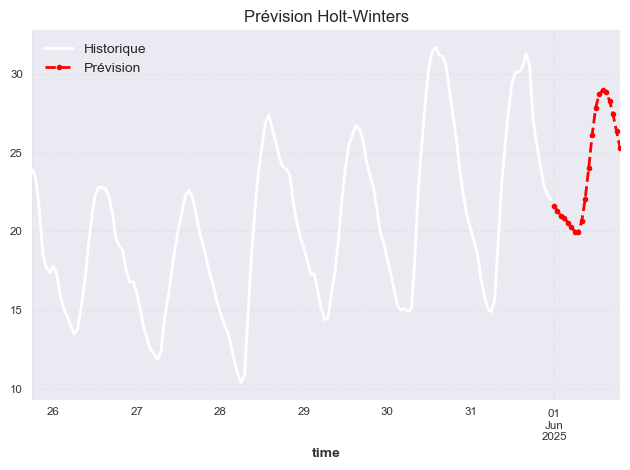

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


df = pd.read_csv("csv/open-meteo-ynov-aix.csv", parse_dates=["time"])
df.set_index("time", inplace=True)
df = df.asfreq('h') 

series = df["apparent_temperature (°C)"]

model = ExponentialSmoothing(
    series,
    trend="add",
    seasonal="add",
    seasonal_periods=24
)

fit = model.fit()
forecast = fit.forecast(steps=20)

series[-150:].plot(label="Historique", linewidth=2, color='white')
forecast.plot(label="Prévision", linewidth=2, color='red', linestyle='--', marker='o', markersize=3)
plt.title("Prévision Holt-Winters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



RMSE: 4.11
MAE: 3.57


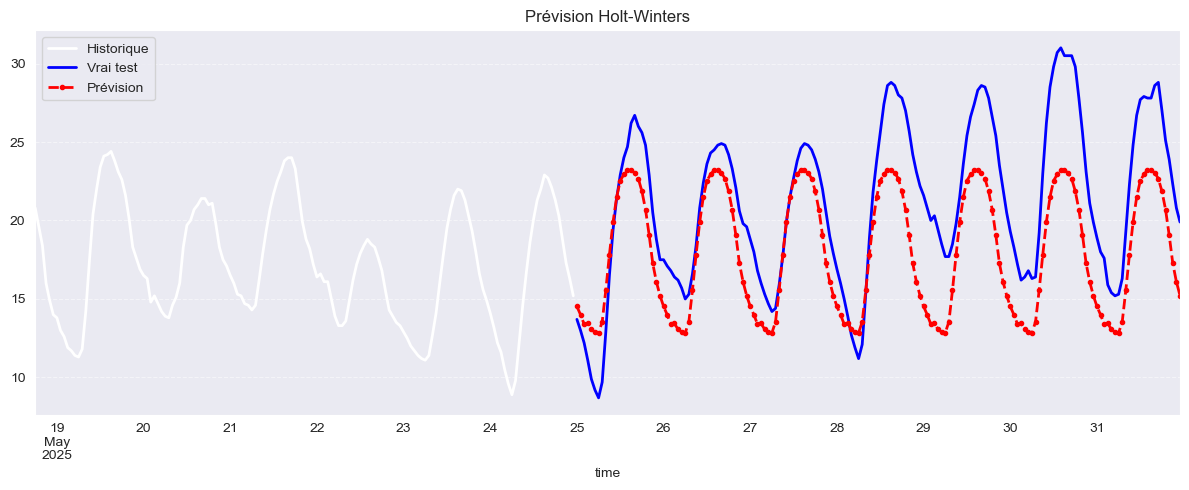

In [10]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("csv/open-meteo-ynov-aix.csv", parse_dates=["time"])
df.set_index("time", inplace=True)
df = df.asfreq('h')
series = df["temperature_2m (°C)"]

# Séparation train/test (7 derniers jours pour test)
test = series[-24*7:]
train = series[:-24*7]

# Modélisation sur train
model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal="add",
    seasonal_periods=24,
    damped_trend=False
)
fit = model.fit()
# Prédiction sur la période de test
forecast = fit.forecast(steps=24*7)

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualisation
plt.figure(figsize=(12,5))
train[-150:].plot(label="Historique", linewidth=2, color='white')
test.plot(label="Vrai test", linewidth=2, color='blue')
forecast.plot(label="Prévision", linewidth=2, color='red', linestyle='--', marker='o', markersize=3)
plt.title("Prévision Holt-Winters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

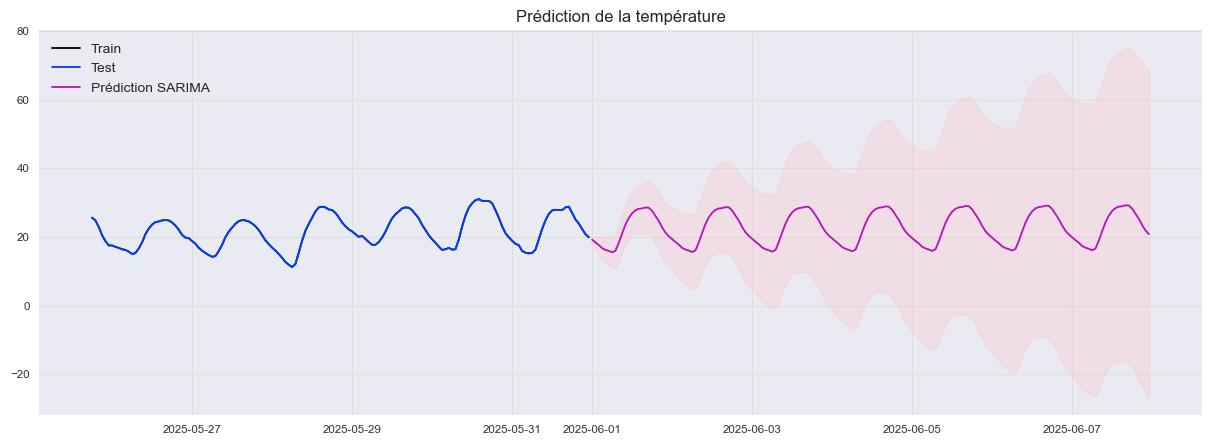

In [7]:
target = "temperature_2m (°C)"
df_target = df[[target]]
train = df_target.iloc[-150:]  # Entraînement sur tout sauf la dernière semaine
test = df_target.iloc[-150:]
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=24*7)  # Prévision pour une semaine
pred = forecast.predicted_mean
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Prédiction SARIMA')
plt.fill_between(pred.index, forecast.conf_int()['lower temperature_2m (°C)'], 
                 forecast.conf_int()['upper temperature_2m (°C)'], color='pink', alpha=0.3)
plt.legend()
plt.title('Prédiction de la température')
plt.show()